<a href="https://colab.research.google.com/github/jgermanob/COCID-PLN/blob/master/notebooks/An%C3%A1lisis_de_sentimientos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4) Clasificación de textos

La clasificación de texto es el proceso de asignación de documentos de texto en dos o más categorías. La forma más común es la clasificación binaria. 

La clasificación de texto suele ser el primer paso en la selección de un conjunto de documentos para enviar para su posterior procesamiento, o puede ser el único paso en el procesamiento de texto (por ejemplo, filtrado de spam). El objetivo de la clasificación de texto no es extraer información de un texto que no sea la categoría del documento. El enfoque básico para la clasificación de texto es derivar un conjunto de características para describir un documento y luego aplicar un algoritmo diseñado para procesar y usar estas características para seleccionar la categoría apropiada para un documento específico.

Para este curso, nos enfocaremos en una tarea común de clasificación de texto, el análisis de sentimientos. Esta tarea consiste en la extracción de sentimientos y la orientación positiva o negativa que un escritor expresa hacia alguna entidad, que puede ser una reseña de una película, un libro, producto de la web, un candidato político, entre otras cosas. Extraer el sentimiento del consumidor o del público es, por lo tanto, relevante para campos que van desde el marketing hasta la política.

La versión más simple del análisis de sentimientos es una tarea de clasificación binaria, y las palabras de la reseña brindan excelentes pistas.

In [ ]:
%%capture
!python -m spacy download en_core_web_sm

#### 4.1) Importación de bibliotecas

In [ ]:
import nltk
import matplotlib.pyplot as plt
import numpy as np
import re
import spacy
from nltk.corpus import stopwords
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#### 4.2) Descargar los conjuntos de datos necesarios

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

Utilizaremos el corpus de [IMDb](https://ai.stanford.edu/~amaas/data/sentiment/). Este conjunto de datos contiene reseñas de películas junto con sus etiquetas de polaridad de sentimiento binarias asociadas. Está destinado a servir como punto de referencia para la clasificación de sentimientos. 

El conjunto de datos central contiene 50,000 reseñas divididas equitativamente en dos subconjuntos; 25,000 instancias para entrenamiento y 25,000 para prueba con una distribución balanceada, es decir, el mismo número de instancias etiquetadas como positivas y negativas. 

In [ ]:
%%capture
!wget https://raw.githubusercontent.com/jgermanob/COCID-PLN/master/Corpora/imdb_train.csv
!wget https://raw.githubusercontent.com/jgermanob/COCID-PLN/master/Corpora/imdb_test.csv

In [ ]:
TRAIN_PATH = 'imdb_train.csv'
TEST_PATH = 'imdb_test.csv'

In [ ]:
train_df = pd.read_csv(TRAIN_PATH, encoding='utf8')
test_df = pd.read_csv(TEST_PATH, encoding='utf8')

In [ ]:
train_df.head()

#### 4.3) Preprocesamiento del texto

In [ ]:
sw = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_sm')

In [ ]:
def text_preprocessing(text):
  # convertir texto a mínusculas
  text = text.lower()
  #eliminar caracteres html
  text = re.sub('<.*?>', '', text)
  #eliminar signos de puntuación
  text = re.sub('[^\w\s]', '', text)

  #tokenización
  words = text.split()

  #eliminar palabras funcionales
  filtered_words = [word for word in words if word not in sw]

  #Unir las palabras procesadas en un texto nuevamente
  processed_text = ' '.join(filtered_words)

  return processed_text


In [ ]:
train_df['preprocessed text'] = train_df['text'].apply(text_preprocessing)

In [ ]:
test_df['preprocessed text'] = test_df['text'].apply(text_preprocessing)

In [ ]:
train_df.head()

#### 4.4) Crear la bolsa de palabras

Representamos un documento de texto como si fuera una bolsa de palabras, es decir, un conjunto desordenado de palabras ignorando su posición, conservando únicamente su frecuencia en el documento.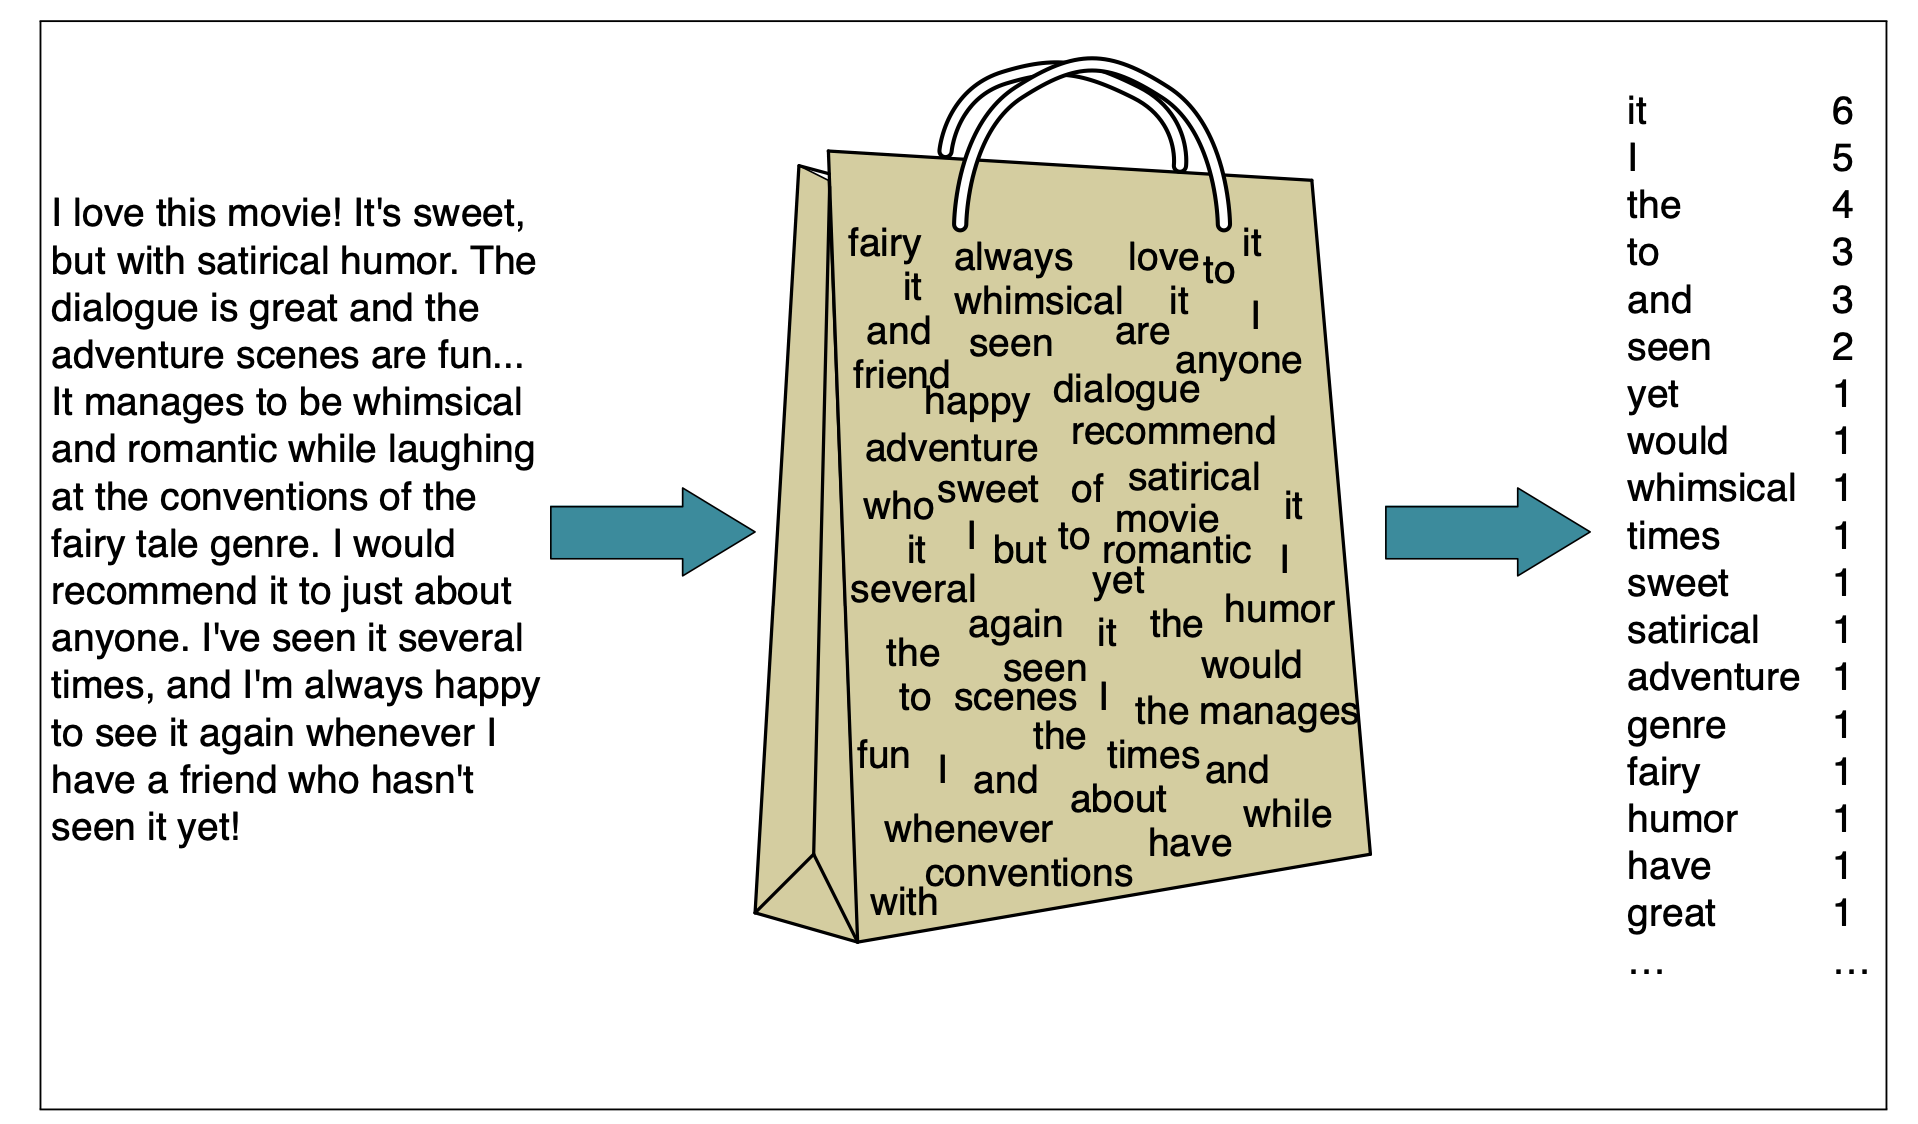

In [ ]:
bow_vectorizer = CountVectorizer()

In [ ]:
x_train_bow = bow_vectorizer.fit_transform(train_df['preprocessed text'])

In [ ]:
x_test_bow = bow_vectorizer.transform(test_df['preprocessed text'])

In [ ]:
y_train = train_df['label']
y_test = test_df['label']

#### 4.5) Entrenar clasificadores con vectores BoW


##### 4.5.1) Regresión logística

La regresión logística es un algoritmo de clasificación que se utiliza para predecir la probabilidad de una variable dependiente categórica. En la regresión logística, la variable dependiente es una variable binaria que contiene datos codificados como 1 – 0, sí – no, abierto – cerrado, etc.

El resultado o variable objetivo es de naturaleza dicotómica. Dicotómica significa que solo hay dos clases posibles.

In [ ]:
lr = LogisticRegression()
lr.fit(x_train_bow, y_train)

In [ ]:
y_pred_lr = lr.predict(x_test_bow)

##### 4.5.2) Máquina de Vectores de soporte

El principal uso de las Máquinas de Soporte Vectorial se da en la clasificación binaria, es decir para separar un conjunto de datos en dos clases diferentes. 

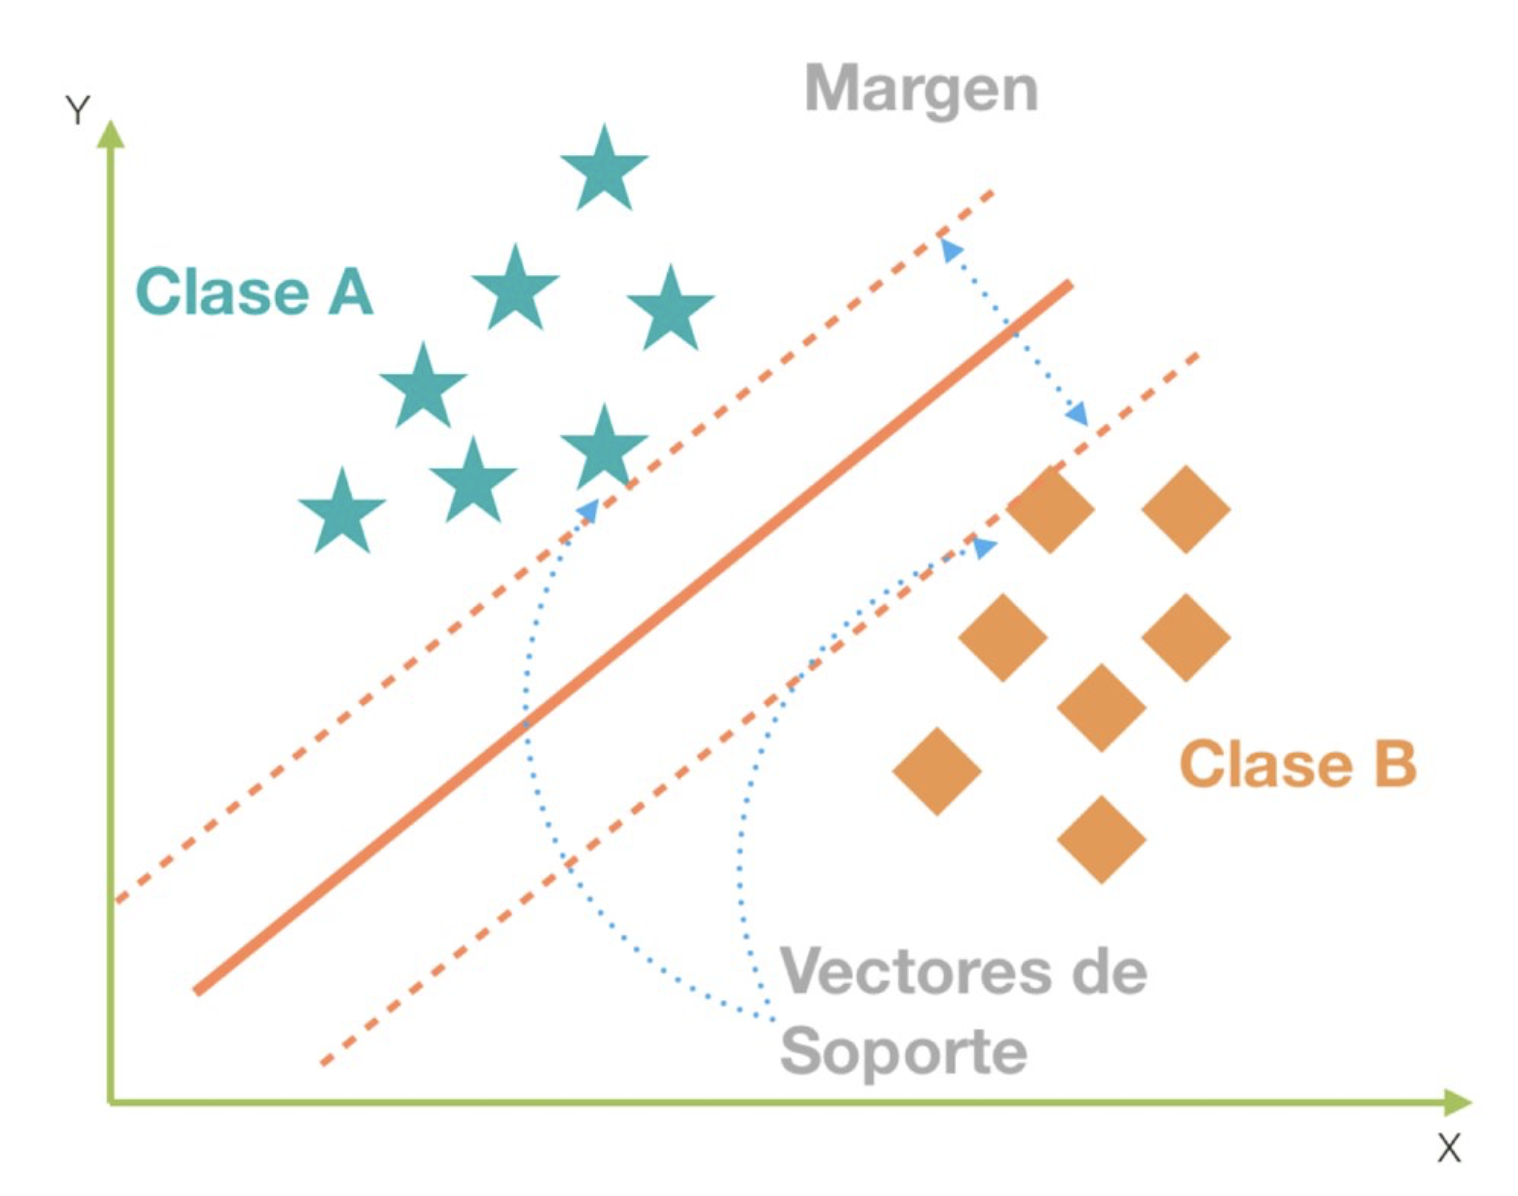

In [ ]:
svm = LinearSVC()
svm.fit(x_train_bow, y_train)

In [ ]:
y_pred_svm = svm.predict(x_test_bow)

##### 4.5.3) Naive-Bayes

Es un algoritmo probabilístico que tiene sus bases en el teorema de Bayes y recibe el apelativo de ingenuo dadas algunas simplificaciones adicionales que determinan la hipótesis de independencia de las variables predictoras.

In [ ]:
nb = MultinomialNB()
nb.fit(x_train_bow, y_train)

In [ ]:
y_pred_nb = nb.predict(x_test_bow)

#### 4.6) Evaluación con Bolsa de palabras

In [ ]:
def evaluate_classifier(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)

  return accuracy, precision, recall, f1

##### 4.6.1) Evaluación de regresión logística

In [ ]:
accuracy_lr, precision_lr, recall_lr, f1_lr = evaluate_classifier(y_test, y_pred_lr) 

##### 4.6.2) Evaluación de Máquina de Vectores de Soporte

In [ ]:
accuracy_svm, precision_svm, recall_svm, f1_svm = evaluate_classifier(y_test, y_pred_svm)

##### 4.6.3) Evaluación de Naive-Bayes

In [ ]:
accuracy_nb, precision_nb, recall_nb, f1_nb = evaluate_classifier(y_test, y_pred_nb)

##### 4.6.4) Comparación de rendimiento

In [ ]:
def plot_performance(accuracy_scores, precision_scores, recall_scores, f1_scores, features, ybotom, ytop):
  labels = ['Regresión Logística', 'SVM', 'Naive Bayes']
  x = np.arange(len(labels))
  width = 0.2
  
  fig, ax = plt.subplots()
  ax.set_ylabel('Scores')
  ax.set_title('Comparación de Rendimiento de Clasificadores usando {}'.format(features))
  
  rects1 = ax.bar(x - width, accuracy_scores, width, label='Accuracy')
  rects2 = ax.bar(x, precision_scores, width, label='Precision')
  rects3 = ax.bar(x + width, recall_scores, width, label='Recall')
  rects4 = ax.bar(x + 2*width, f1_scores, width, label='F1-Score')
  
  ax.set_xticks(x + width)
  ax.set_xticklabels(labels)
  ax.set_ylim(ybotom, ytop)
  ax.legend()
  ax.grid()
  
  for i,acs in zip(x, accuracy_scores):
    ax.text(x[i] - 1.5*width, acs, str(round(acs,3)), rotation=45,)
    
  for i,prec in zip(x, precision_scores):
    ax.text(x[i], prec, str(round(prec,3)), rotation=45,)
    
  for i,rec in zip(x, recall_scores):
    ax.text(x[i] + 0.8*width, rec, str(round(rec,3)), rotation=45,)
    
  for i,f1 in zip(x, f1_scores):
    ax.text(x[i] + 2*width, f1, str(round(f1,3)), rotation=45,)
  
  fig.tight_layout()



In [ ]:
accuracy_scores_bow = [accuracy_lr, accuracy_svm, accuracy_nb]
precision_scores_bow = [precision_lr, precision_svm, precision_nb]
recall_scores_bow = [recall_lr, recall_svm, recall_nb]
f1_scores_bow = [f1_lr, f1_svm, f1_nb]

In [ ]:
plot_performance(accuracy_scores_bow, precision_scores_bow, recall_scores_bow, f1_scores_bow, 'Bolsa de palabras', 0.75, 0.95)

|Clasificador|Accuracy|Precision|Recall|F1-score|
|:---:|:---:|:---:|:---:|:---:|
|Regresión logística|0.866|0.871|0.859|0.865|
|Máquina de vectores de soporte|0.848|0.855|0.837|0.846|
|Naive-Bayes|0.826|0.864|0.774|0.816|

#### 4.7) Crear vectores con TF-IDF

(frecuencia de término – frecuencia inversa de documento), es un esquema de ponderación numérico que expresa que tan relevante es una palabra para un documento en un conjunto de datos.  

$$
TF(t,d) = \frac{count(t,d)}{\#\ tokens\ d}
$$

$$
IDF(t) = log(\frac{N}{1+df})
$$

Donde:
* $N$ Número total de documentos con el conjunto de datos.

* $df$ número de documentos con el término $t$.

In [ ]:
tfidf_vectorizer = TfidfVectorizer()

In [ ]:
x_train_tfidf = tfidf_vectorizer.fit_transform(train_df['preprocessed text'])

In [ ]:
x_test_tfidf = tfidf_vectorizer.transform(test_df['preprocessed text'])

#### 4.8) Entrenar clasificadores con vectores TF-IDF

##### 4.8.1) Regresión logística

In [ ]:
lr = LogisticRegression()
lr.fit(x_train_tfidf, y_train)

In [ ]:
y_pred_lr = lr.predict(x_test_tfidf)

###### 4.8.2) Máquina de Vectores de Soporte

In [ ]:
svm = LinearSVC()
svm.fit(x_train_tfidf, y_train)

In [ ]:
y_pred_svm = svm.predict(x_test_tfidf)

##### 4.8.3) Naive-Bayes

In [ ]:
nb = MultinomialNB()
nb.fit(x_train_tfidf, y_train)

In [ ]:
y_pred_nb = nb.predict(x_test_tfidf)

#### 4.9) Evaluación con TF-IDF 

##### 4.9.1) Evaluación de regresión logística

In [ ]:
accuracy_lr, precision_lr, recall_lr, f1_lr = evaluate_classifier(y_test, y_pred_lr) 

##### 4.9.2) Evaluación con máquina de vectores de soporte

In [ ]:
accuracy_svm, precision_svm, recall_svm, f1_svm = evaluate_classifier(y_test, y_pred_svm) 

##### 4.9.3) Evaluación con Naive-Bayes

In [ ]:
accuracy_nb, precision_nb, recall_nb, f1_nb = evaluate_classifier(y_test, y_pred_nb) 

##### 4.9.4) Comparación de rendimiento

In [ ]:
accuracy_scores_tfidf = [accuracy_lr, accuracy_svm, accuracy_nb]
precision_scores_tfidf = [precision_lr, precision_svm, precision_nb]
recall_scores_tfidf = [recall_lr, recall_svm, recall_nb]
f1_scores_tfidf = [f1_lr, f1_svm, f1_nb]

In [ ]:
plot_performance(accuracy_scores_tfidf, precision_scores_tfidf, recall_scores_tfidf, f1_scores_tfidf, 'TF-IDF', 0.75, 0.95)

|Clasificador|Accuracy|Precision|Recall|F1-score|
|:---:|:---:|:---:|:---:|:---:|
|Regresión logística|0.882|0.881|0.884|0.883|
|Máquina de vectores de soporte|0.874|0.881|0.865|0.873|
|Naive-Bayes|0.837|0.868|0.795|0.830|

#### Ejercicio

* En la función `text_preprocessing(text)` agrega una expresión regular para identificar los digitos y eliminalos de las reseñas. Entrena los diferentes clasificadores y compara el rendimiento obtenido sin eliminar los digitos.